In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report, jaccard_score, log_loss, mean_squared_error, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE

## IMPORT DATASET

Calling the dataset in csv format and stored in the "df_train" variable then displaying the top 5 data using the .head() syntax



In [2]:
df = pd.read_csv("data/bankrupt.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Exploratory Data Analysis (EDA)

In the early stages of EDA, the first thing to do is look at the information from the dataset using the info() syntax. By using this syntax we can see the amount of data in each column and the data type. Because this dataset aims to predict whether the company will go bankrupt or not, the data needed is data in int and float format. from this dataset it can also be seen that there are 95 features and 1 target. After that other information can be seen using the syntax describe(). With this syntax we can see the average value and standard deviation of the dataset.

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Look at the dataset whether there are null and duplicate data

In [5]:
print("=========== null of dataset================== ")
print(df.isnull().values.any())
print("=========== Sum Duplicate of dataset================== ")
df[df.duplicated()]

=========== null of dataset================== 
False
=========== Sum Duplicate of dataset================== 


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability


Because this dataset is included in the classification, balancing the target data must be considered. How to see it can use the value_counts() syntax to find out the amount of data in each column.

In [6]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## Preprocessing Data

The first stage is to overcome the problem of data inbalancing. From the EDA process we can find out the amount of data in class 0 in the target column there are 6599 data and class 0 is 220 data. With this amount of data I try to use SMOTE because if you use Undersampling then around 6300 data will be wasted.

In [7]:
X = df.drop('Bankrupt?', axis=1).reset_index(drop=True)
y = df['Bankrupt?'].reset_index(drop=True)

In [8]:
# SMOTE on Datasets
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, y.ravel())

# Give back value after SMOTE to df
df = X_smote
df['Bankrupt'] = y_smote

In [9]:
df['Bankrupt'].value_counts()

1    6599
0    6599
Name: Bankrupt, dtype: int64

Then I try to check again whether there are null or duplicate data. This stage is optional and can be done again or not.

In [10]:
print("=========== Sum null of dataset================== ")
print(df.isnull().values.any())
print("=========== Sum Duplicate of dataset================== ")
df[df.duplicated()]

=========== Sum null of dataset================== 
False
=========== Sum Duplicate of dataset================== 


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt


After that look at the correlation between the data. In the image below, what must be seen is the correlation between the Bankrupt data and other data. If you look at the picture, the highest correlation is found in Borrowing Dependency.



<AxesSubplot:>

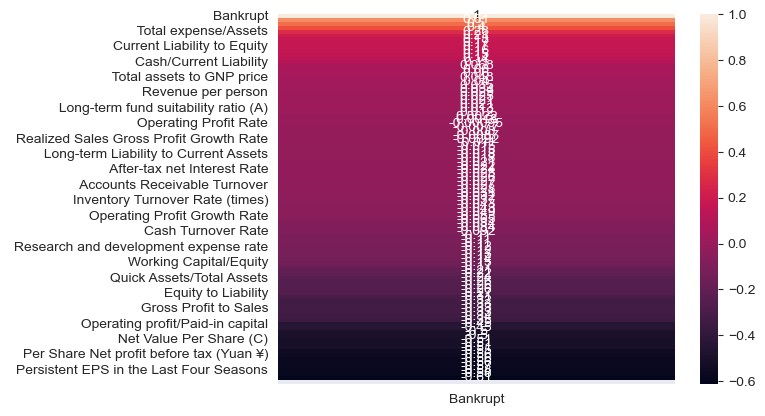

In [11]:
corr = df.corr()[['Bankrupt']].sort_values(by='Bankrupt', ascending=False)
sns.heatmap(corr, annot=True)

Then look at the distribution of data in the dataset using boxplot plots. By using a boxplot you can also check whether the data has outliers or not. If there is then the outlier must be removed.



The following is the syntax for removing outliers in the dataset.

In [12]:
for i in df.columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df[i] = np.where(df[i] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR), df[i])
    df[i] = np.where(df[i] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR), df[i])

Check again whether the outlier data has been deleted or not.

In [13]:
# for column in df:
#     plt.figure()
#     df.boxplot([column])

After that, also look at the distribution of data using histogram plotting.

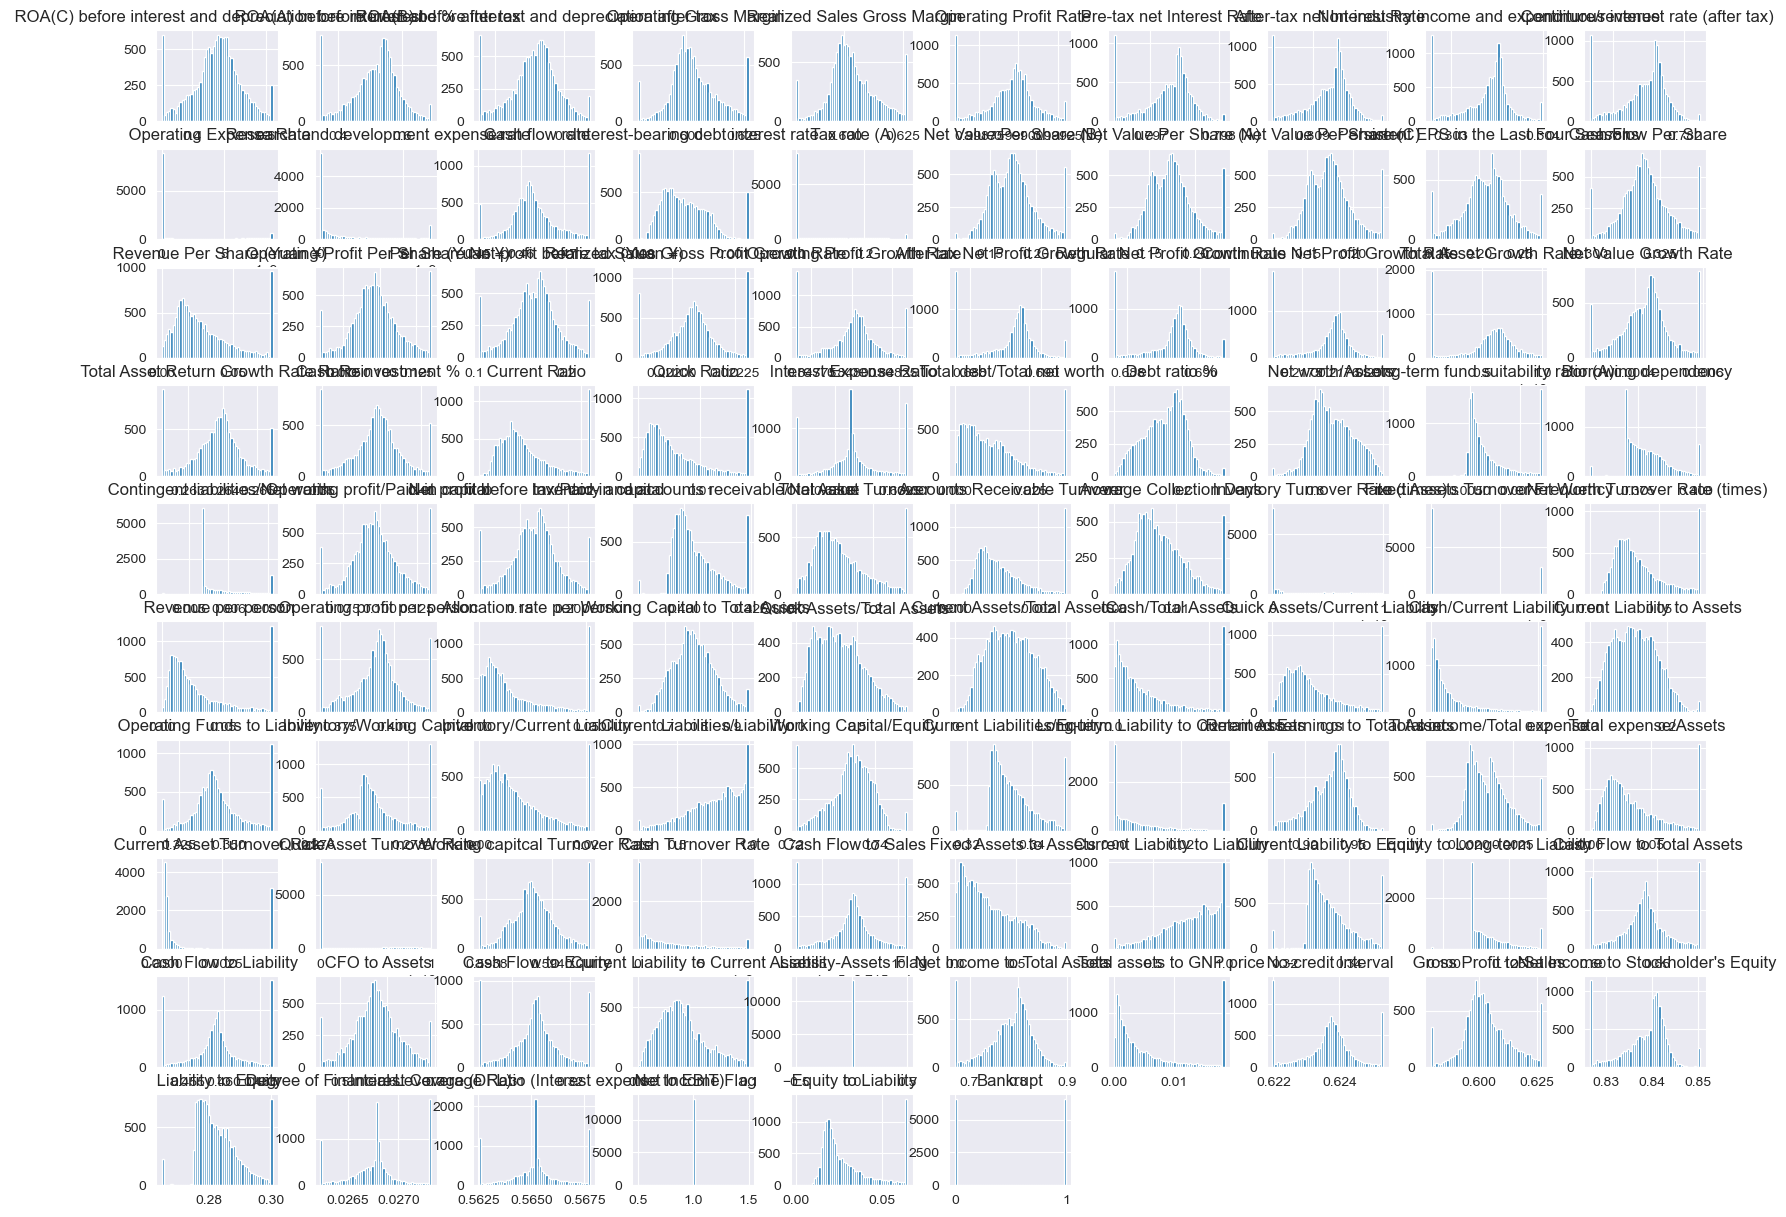

In [14]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

After the information from the dataset is sufficient, the next step is to separate the data between feature data and target data. The reason is because the next stage is data scaling and data scaling is only done on feature data.

In [15]:
X = df.drop('Bankrupt', axis=1).reset_index(drop=True)
y = df['Bankrupt'].reset_index(drop=True)

At this stage, scaling the data using a standard scaler. The purpose of the standard scaler is to make the mean value 0 and the variance 1.

In [16]:
tf = StandardScaler().fit_transform(X)
scaledf = pd.DataFrame(tf, columns=X.columns)
scaledf['Bankrupt'] = y
scaledf

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt
0,-1.425268,-1.181554,-1.517766,-0.181127,-0.183119,0.178643,-0.986022,-1.070578,-2.071706,-1.254340,...,0.598578,-0.857329,-0.181331,-1.872234,0.950210,-0.647583,-0.805226,0.0,-0.852887,1.0
1,-0.018161,0.310012,0.063917,0.666008,0.667601,0.037937,0.374525,0.393942,0.650602,0.253420,...,0.446927,0.031450,0.666224,0.363986,0.065721,1.748530,1.803681,0.0,-0.579804,1.0
2,-0.592131,-0.203607,-0.569366,-0.181822,-0.192199,-0.498986,-2.160981,-2.149019,-2.071706,-2.175284,...,2.122758,0.249160,-0.181713,-0.227504,0.948351,-0.798723,-1.047081,0.0,-0.852547,1.0
3,-0.986004,-0.829379,-0.776900,-1.910172,-1.919482,-1.453827,-0.765754,-0.604912,-0.071899,-0.513252,...,-0.411194,-0.800111,-1.910140,-0.612060,-0.229965,-0.331537,-0.374073,0.0,-0.378536,1.0
4,-0.007179,0.312869,0.143269,-0.439162,-0.442246,0.202444,0.335586,0.402868,0.366159,0.380928,...,-0.305412,-0.119264,-0.439150,0.364629,-0.676307,-1.888714,1.803681,0.0,0.347982,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,-2.203874,-1.762560,-1.698342,0.961730,0.977206,-1.049804,-0.576955,-0.501273,-0.141606,-0.464091,...,0.092641,0.516496,0.961445,-1.178356,-0.503585,-0.230616,-0.282966,0.0,0.118916,1.0
13194,-2.205590,-2.138438,-2.252219,-0.554442,-0.555603,0.269619,-0.083879,-0.067454,-0.642161,-0.064977,...,-0.466230,-0.334164,-0.554446,2.321734,-2.580281,-0.053866,-0.073217,0.0,-1.205089,1.0
13195,-1.803189,-1.540581,-1.755584,-0.212231,-0.214354,-0.181662,-0.702411,-0.620869,-1.465731,-0.707475,...,-0.760405,-0.303888,-0.212183,-2.162539,2.382293,-0.243672,-0.276756,0.0,-0.730586,1.0
13196,0.053154,0.039688,0.189193,0.856996,0.859397,0.261998,-0.333665,-0.209551,-1.185363,-0.165795,...,-0.822098,0.237283,0.856754,0.171273,0.219364,1.748530,1.523834,0.0,-0.641851,1.0


Checks whether the mean value on the df scale is close to 0 and the standard deviation is 1

In [17]:
print(scaledf.isnull().values.any())
scaledf.describe()

False


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt
count,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,...,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,13198.0,1.319800e+04,13198.000000
mean,1.945540e-16,4.210177e-15,-3.023713e-17,2.968101e-15,-3.534140e-15,-5.983320e-13,-1.516070e-13,5.029208e-14,-1.334484e-13,-2.905430e-14,...,1.012403e-15,1.299247e-13,-1.326741e-15,2.814436e-14,8.515402e-16,-6.336128e-15,3.109617e-15,0.0,4.578774e-15,0.500000
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,...,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,0.0,1.000038e+00,0.500019
min,-2.236411e+00,-2.252979e+00,-2.252219e+00,-2.337351e+00,-2.333271e+00,-2.083555e+00,-2.160981e+00,-2.149019e+00,-2.071706e+00,-2.175284e+00,...,-9.616011e-01,-1.911162e+00,-2.337733e+00,-2.162539e+00,-2.580281e+00,-1.888714e+00,-1.873679e+00,0.0,-1.892596e+00,0.000000
25%,-5.332942e-01,-5.278813e-01,-5.324665e-01,-6.037506e-01,-6.014521e-01,-4.816200e-01,-4.811764e-01,-4.709690e-01,-4.813674e-01,-4.817255e-01,...,-7.586264e-01,-4.596521e-01,-6.038078e-01,-4.809368e-01,-7.193161e-01,-5.247473e-01,-4.946689e-01,0.0,-7.356021e-01,0.000000
50%,5.995723e-02,1.578551e-01,1.027173e-01,-1.428737e-01,-1.443158e-01,1.715320e-01,2.538960e-01,2.892297e-01,2.640782e-01,2.640158e-01,...,-4.311199e-01,1.126901e-01,-1.426809e-01,3.058625e-01,-1.933327e-01,-2.036461e-02,-2.132983e-02,0.0,-3.990326e-01,0.500000
75%,6.021167e-01,6.221837e-01,6.140351e-01,5.519828e-01,5.530936e-01,5.863364e-01,6.386936e-01,6.477306e-01,5.788585e-01,6.473136e-01,...,3.939273e-01,5.080213e-01,5.521422e-01,6.401313e-01,5.213273e-01,3.845637e-01,4.246710e-01,0.0,4.285969e-01,1.000000
max,2.305233e+00,2.347281e+00,2.333787e+00,2.285583e+00,2.284912e+00,2.188271e+00,2.318499e+00,2.325780e+00,2.169197e+00,2.340872e+00,...,2.122758e+00,1.959531e+00,2.286067e+00,2.321734e+00,2.382293e+00,1.748530e+00,1.803681e+00,0.0,2.174896e+00,1.000000


Then the data that has been scaled will be divided into 4 parts, namely x_test, x_train, y_train, and y_test. The division of the data is 80% train data and 20% test data.


In [18]:
xx = scaledf.drop('Bankrupt', axis=1)
yy = scaledf['Bankrupt']
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10558, 95) (10558,) (2640, 95) (2640,)


Create a validation variable by means of reverse data.

In [19]:
x_val = X_train[-2640:]
y_val = y_train[-2640:]

## Modelling

Create a model with 3 layers, namely 1 input layer, 1 hidden layer, and 1 output layer. The input layer uses 95 nodes and requires relative activation. 95 nodes were chosen because in the input layer the number of nodes is the number of features used and because the data that has been scaled has negative value data, relu activation is used. After that, the hidden layer uses 2 nodes and activates Relu. Then the output layer uses 1 number of nodes and the sigmoid activation function. The number of these nodes depends on the type of classification contained in the dataset, because the dataset has 2 classes in the target column, this classification is called binary classification. And Binary classification uses the sigmoid activation function for the output layer with the number of nodes 1.

In [109]:
model = keras.Sequential([
    layers.BatchNormalization(input_dim=95),
    layers.Dense(95, activation='relu', input_dim=95),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(2, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

In [110]:
# model = keras.Sequential()
# model.add(Dense(units=95, activation='relu', input_dim=95))  #input layer
# model.add(Dense(units=2, activation='relu'))  #hidden layer
# model.add(Dense(units=1, activation='sigmoid'))  # output layer

Here is a summery model that has been made

In [111]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_23 (Bat  (None, 95)               380       
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 95)                9120      
                                                                 
 batch_normalization_24 (Bat  (None, 95)               380       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 95)                0         
                                                                 
 dense_34 (Dense)            (None, 2)                 192       
                                                                 
 batch_normalization_25 (Bat  (None, 2)              

The next stage is compiling the model. The optimizer used is ADAM with a learning rate of 0.0001. Then the loss used is Binary crossentropy, this loss was chosen because for the binary class loss classification case used is Binary crossentropy. And for the metrics use accuracy.

In [112]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

Then the model will be fitted with batch size 16 and epoch 30. And obtained loss 0..03, accuracy 0.99, val loss 0.02, and val accuracy 0.99



In [113]:
history = model.fit(
    X_train,
    y_train,
    batch_size=30,
    epochs=50,
    validation_data=(x_val, y_val),
)

Epoch 1/50
352/352 [==============================] - 7s 8ms/step - loss: 0.3369 - accuracy: 0.8750 - val_loss: 0.1947 - val_accuracy: 0.9462
Epoch 2/50
352/352 [==============================] - 2s 7ms/step - loss: 0.2348 - accuracy: 0.9173 - val_loss: 0.1270 - val_accuracy: 0.9652
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1912 - accuracy: 0.9340 - val_loss: 0.0953 - val_accuracy: 0.9758
Epoch 4/50
352/352 [==============================] - 2s 7ms/step - loss: 0.1685 - accuracy: 0.9415 - val_loss: 0.0854 - val_accuracy: 0.9826
Epoch 5/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1384 - accuracy: 0.9517 - val_loss: 0.0601 - val_accuracy: 0.9852
Epoch 6/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1333 - accuracy: 0.9545 - val_loss: 0.0549 - val_accuracy: 0.9875
Epoch 7/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1223 - accuracy: 0.9549 - val_loss: 0.0450 - val_accuracy: 0.9894
Epoch 

## Model Evaluation

Plotting the loss and accuracy of the model that has been made.

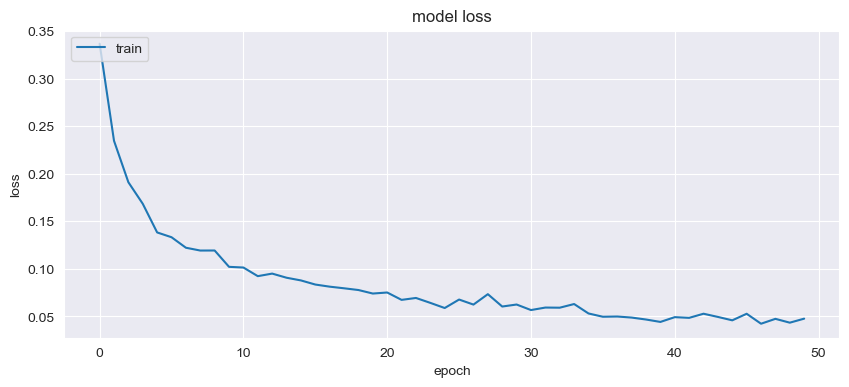

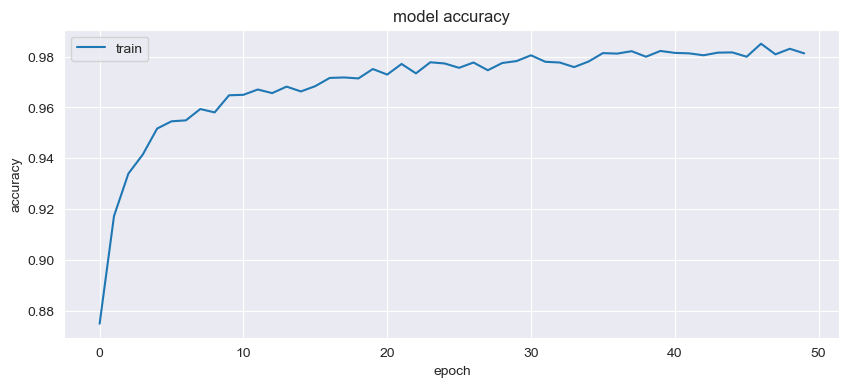

In [114]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

syntax to get prediction results using np.round

In [115]:
kelas = np.round(model.predict(X_test), 0)
hasil_prediksi = np.asarray(kelas, dtype='int')
print(hasil_prediksi)
ypred = hasil_prediksi

83/83 [==============================] - 1s 3ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


The following is the confusion matrix of the model

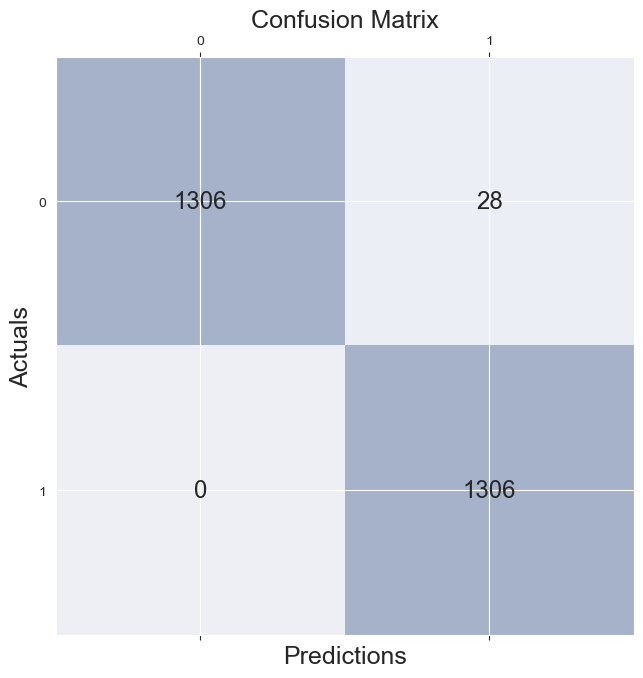

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1306
           1       1.00      0.98      0.99      1334

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640



In [116]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
report = classification_report(ypred, y_test)
print(report)